In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
pd.set_option("display.max_columns", 500)

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import sklearn
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import VotingClassifier

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, mean_squared_log_error 

from scipy.stats import skew,boxcox_normmax, zscore

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

In [3]:
test_house = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
train_house = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")

In [4]:
test_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(test_house.shape)

(1459, 80)


In [6]:
train_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_house.shape

(1460, 81)

In [8]:
sample_solution = pd.read_csv("/kaggle/input/home-data-for-ml-course/sample_submission.csv")
sample_solution.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [9]:
print(train_house.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [10]:
print(test_house.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [11]:
with open("/kaggle/input/home-data-for-ml-course/data_description.txt", "r") as file:
    content = file.read()
    print(content)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## EDA

- Check for normality
- Check for missing values
- Check for outliers

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


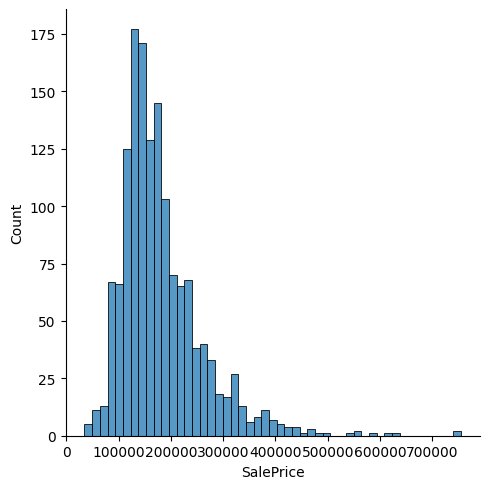

In [12]:
# Dependent variable (SalePrice) is right skewed, so will need to do log transformation to achieve normality

sns.displot(train_house.get("SalePrice"), kind="hist")

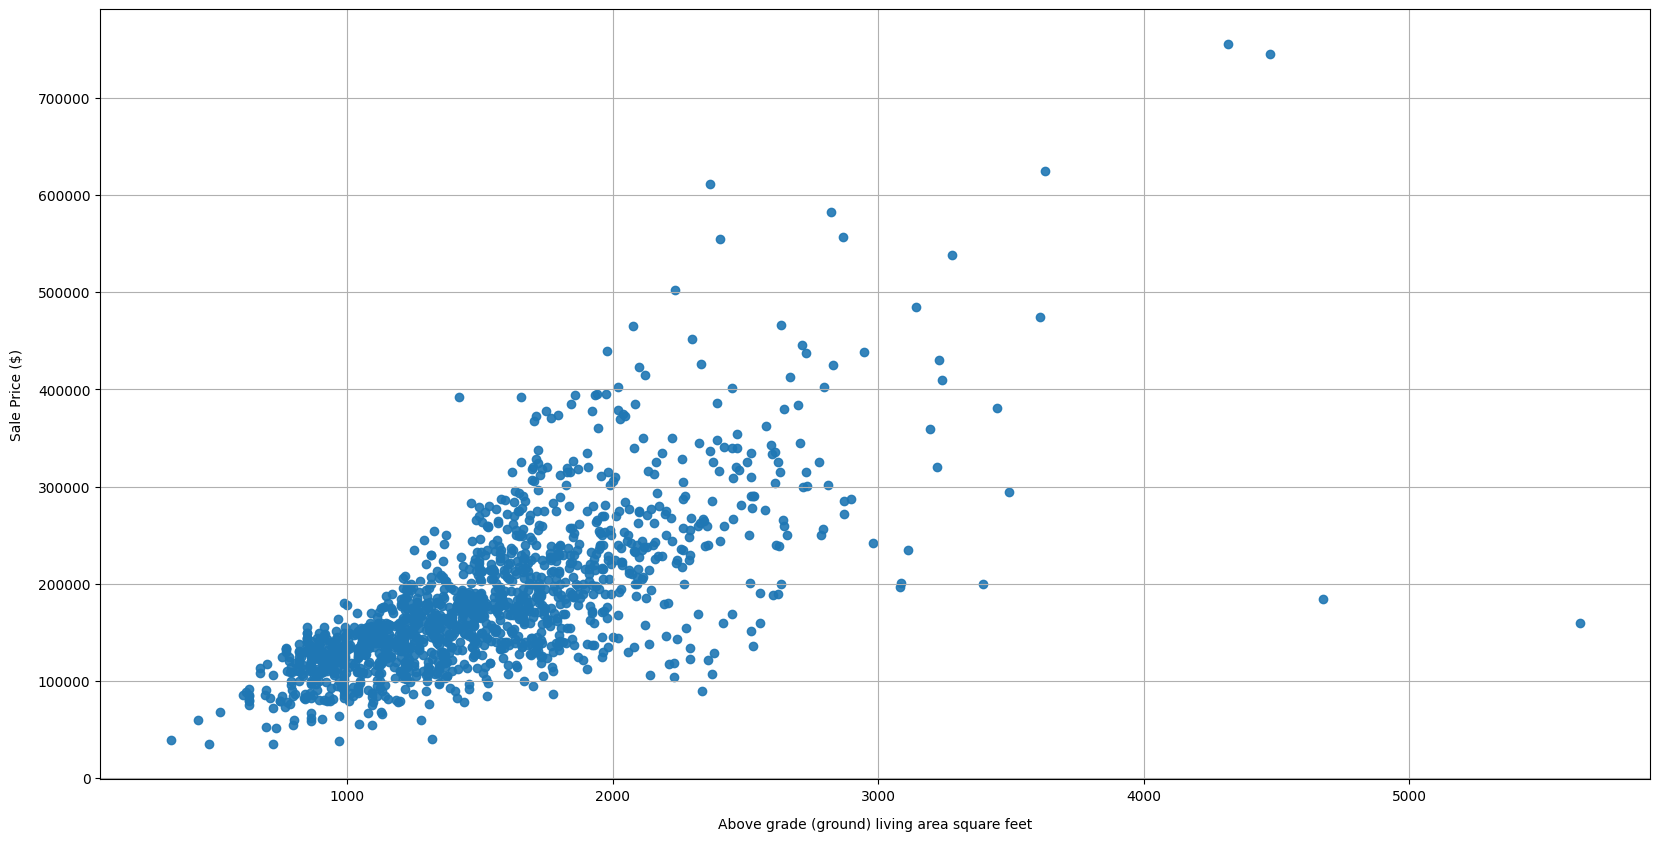

In [13]:
# Outlier Detection

fig, ax = plt.subplots(figsize=(20, 10))

ax.grid()
ax.scatter(train_house["GrLivArea"], train_house["SalePrice"], alpha=0.9)
ax.set_xlabel("Above grade (ground) living area square feet", labelpad=10)
ax.set_ylabel("Sale Price ($)", labelpad=10)

plt.show()

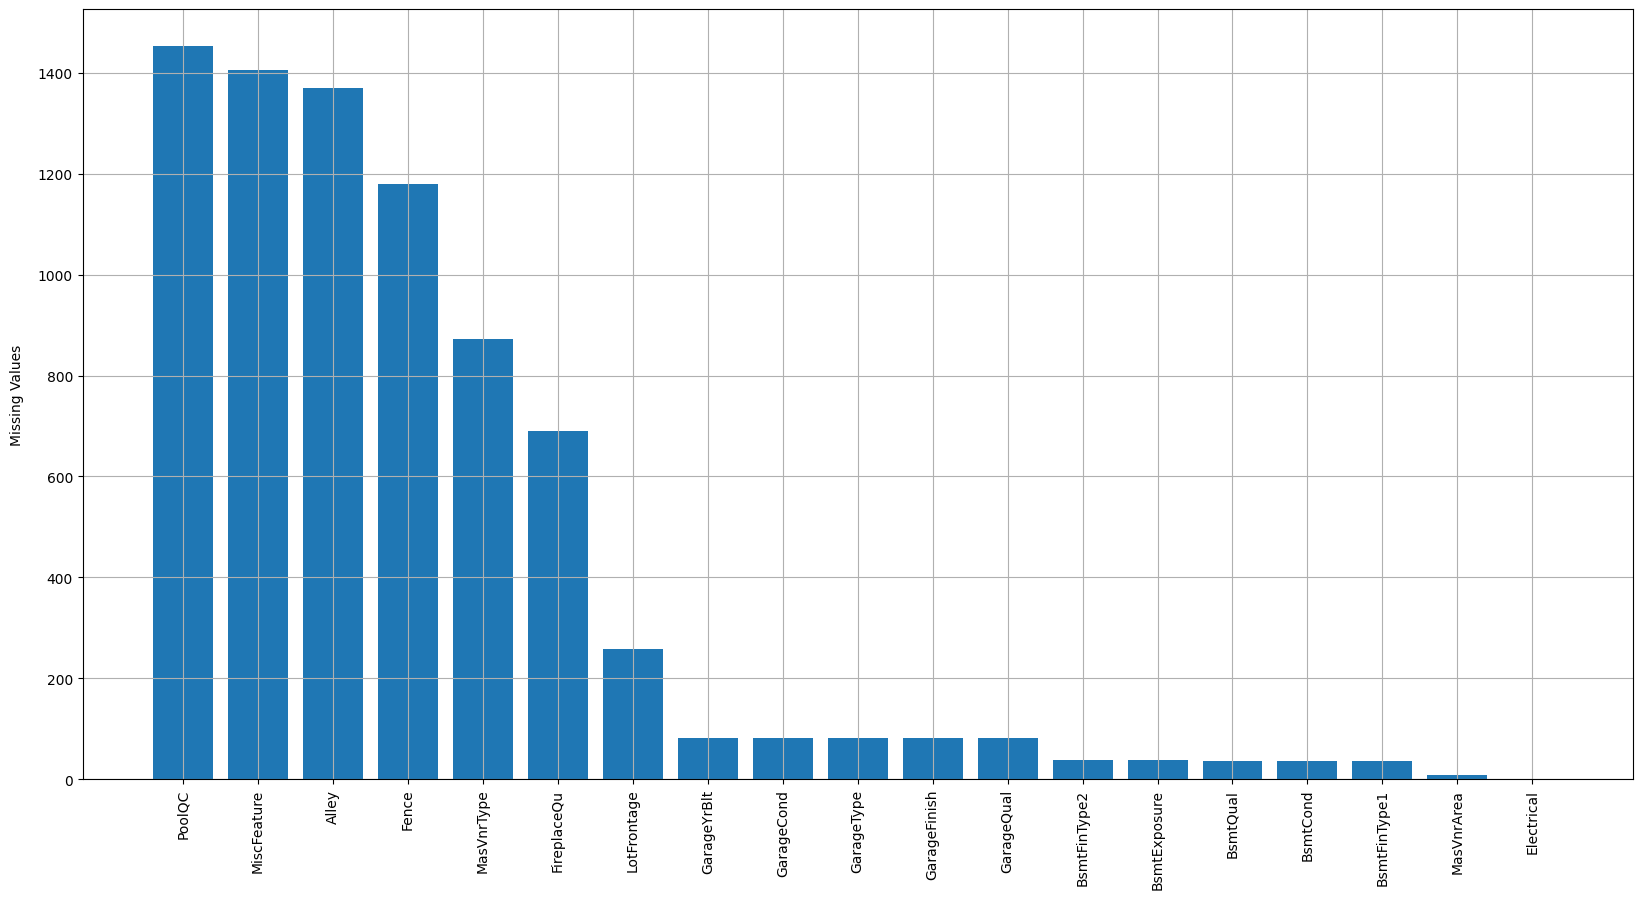

In [14]:
# Missing Values

missing_values = train_house.isna().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

fig, ax = plt.subplots(figsize=(20, 10))
ax.grid()
ax.bar(missing_values.index, missing_values.values)
ax.set_ylabel("Missing Values", labelpad=10)
ax.xaxis.set_tick_params(rotation=90)

plt.show()

In [15]:
# Log Transformation (Train)
log_trans = np.log(train_house["SalePrice"])

## Feature Engineering

- Address missing values
- Modify/ create new columns

In [16]:
# PoolQC, MiscFeature, Alley, Fence, MasVnType, FireplaceQU, LotFrontage, GarageYrBit, GarageCond, GarageType, GarageFinish, GarageQual, BstmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1, MasVnrArea, Electrical

test_house.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [17]:
combined_data = pd.concat([train_house, test_house], ignore_index=True)

handle_missing = combined_data.isnull().sum()

# Mean --> Numerical
# Mode --> Categorical (None?)
for i in combined_data.columns:
    if combined_data[i].dtype == "object":
        combined_data[i] = combined_data[i].fillna(combined_data[i].mode()[0])
    else:
        combined_data[i] = combined_data[i].fillna(combined_data[i].mean())

# Categorical --> Label Encoding
le = LabelEncoder()

for i in combined_data.columns:
    if combined_data[i].dtype == "object":
        combined_data[i] = le.fit_transform(combined_data[i])

## Training

- Test performance
- Tune model if needed (e.g. ensemble)

In [18]:
# Try out Box Cox for achieving normality vs log transformation
train_target = train_house["SalePrice"]
train_boxcox = boxcox(train_target + 1)[0]

train_house1 = combined_data[:len(train_house)]
test_house1 = combined_data[len(train_house):]

# Split into features and target
X_train = train_house1.drop("SalePrice", axis=1)
y_train = train_boxcox
X_test = test_house1.drop("SalePrice", axis=1)

models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'GBM': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    #'LGBM': lgb.LGBMRegressor(),
    'SVR': SVR(),
    # 'RandomForest': RandomForestRegressor()
}

# Hyperparameter + Tuning
param_grids = {
    'Lasso': {'alpha': [0.1, 0.5, 1, 5]},
    'Ridge': {'alpha': [0.1, 0.5, 1, 5]},
    'ElasticNet': {'alpha': [0.1, 0.5, 1, 5], 'l1_ratio': [0.2, 0.5, 0.8]},
    'GBM': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.05, 0.01]},
    'XGBoost': {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [50, 100, 200], 'gamma': [0, 0.25, 1.0]},
    #'LGBM': {'num_leaves': [31, 62, 127], 'max_depth': [-1, 5, 10], 'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [50, 100, 200]},
    'SVR': {'C': [1, 5, 10], 'epsilon': [0.1, 0.5, 1]}
    # 'RandomForest': {
    #     'n_estimators': [50, 100, 200],
    #     'max_depth': [None, 5, 10],
    #     'max_features': ['sqrt', 'log2', 0.5],  # Avoid Auto
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 5, 10],
    #     'bootstrap': [True, False]
    # }
}

rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring=rmsle_scorer)
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best Score for {name}: {grid_search.best_score_}")

    best_models[name] = grid_search.best_estimator_

Best Parameters for Lasso: {'alpha': 0.1}
Best Score for Lasso: -7.347070537444002e-05
Best Parameters for Ridge: {'alpha': 5}
Best Score for Ridge: -4.74350026792338e-05
Best Parameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.2}
Best Score for ElasticNet: -6.656768347058528e-05
Best Parameters for GBM: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score for GBM: -3.2570464896755405e-05
Best Parameters for XGBoost: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score for XGBoost: -3.3998295005670766e-05
Best Parameters for SVR: {'C': 10, 'epsilon': 0.1}
Best Score for SVR: -7.839836125975486e-05


## Results + Submission

- Performance: 

In [19]:
# Predict with each model + combine
predictions = []

for name, model in best_models.items():
    predictions.append(model.predict(X_test))

# Ensemble of predictions
ensemble_prediction = np.mean(predictions, axis=0)

In [20]:
# Invert box cox transformation for final submission
best = np.exp(ensemble_prediction) - 1

submission_df = pd.DataFrame({'Id': test_house1['Id'], 'SalePrice': best})
submission_df.to_csv('submission.csv', index=False)

print("Done")

Done


### Score
- 180377.52276
- @ 6908 on leaderboard at time of submission